# **[MED] [3D] [GEN] CT GAN**

A GAN based framework for adding and removing medical evidence in 3D volumetric medical scans

[![GitHub watch](https://img.shields.io/github/watchers/LeonidAlekseev/CT-GAN.svg?style=social&label=Watch&maxAge=2592000)](https://github.com/LeonidAlekseev/CT-GAN/)

## Environment

Create conda env with yml file and activate

```
conda env create -f environment.yml
conda activate ct_gan
```

In [1]:
!conda info --envs

# conda environments:
#
base                     /home/natitov/miniforge
avtostrah                /home/natitov/miniforge/envs/avtostrah
ct_gan                *  /home/natitov/miniforge/envs/ct_gan
hack_lct                 /home/natitov/miniforge/envs/hack_lct



In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

## Data

### Load

In [6]:
!mkdir -p ~/.kaggle
!echo '{"username":"lifeadmin","key":"6f10a571b9c061cdbc37e224f50c42eb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!mkdir -p ../data

!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer -p ../data
!unzip -qq ../data/medical-deepfakes-lung-cancer.zip -d ../data

!mv -v ../data/CT_Scans/EXP1_blind/* ../data/CT_Scans/
!mv -v ../data/CT_Scans/EXP2_open/* ../data/CT_Scans/

renamed '../data/CT_Scans/EXP1_blind/1003' -> '../data/CT_Scans/1003'
renamed '../data/CT_Scans/EXP1_blind/1005' -> '../data/CT_Scans/1005'
renamed '../data/CT_Scans/EXP1_blind/1009' -> '../data/CT_Scans/1009'
renamed '../data/CT_Scans/EXP1_blind/1045' -> '../data/CT_Scans/1045'
renamed '../data/CT_Scans/EXP1_blind/1067' -> '../data/CT_Scans/1067'
renamed '../data/CT_Scans/EXP1_blind/1201' -> '../data/CT_Scans/1201'
renamed '../data/CT_Scans/EXP1_blind/1219' -> '../data/CT_Scans/1219'
renamed '../data/CT_Scans/EXP1_blind/1280' -> '../data/CT_Scans/1280'
renamed '../data/CT_Scans/EXP1_blind/1356' -> '../data/CT_Scans/1356'
renamed '../data/CT_Scans/EXP1_blind/1402' -> '../data/CT_Scans/1402'
renamed '../data/CT_Scans/EXP1_blind/1411' -> '../data/CT_Scans/1411'
renamed '../data/CT_Scans/EXP1_blind/1438' -> '../data/CT_Scans/1438'
renamed '../data/CT_Scans/EXP1_blind/1452' -> '../data/CT_Scans/1452'
renamed '../data/CT_Scans/EXP1_blind/1531' -> '../data/CT_Scans/1531'
renamed '../data/CT_

In [2]:
import pandas as pd

labels_exp1 = pd.read_csv('../data/labels_exp1.csv')
labels_exp2 = pd.read_csv('../data/labels_exp2.csv')
labels = pd.concat((labels_exp1, labels_exp2), axis=0)
print(labels['type'].value_counts())
labels.head()

FB    72
FM    41
TM    35
TB    21
Name: type, dtype: int64


,type,uuid,slice,x,y
0,FB,1280,100,323,381
1,FB,1009,76,354,288
2,FB,7794,79,163,191
3,FB,7794,94,338,243
4,FB,2997,45,156,135


Classes

* True-Benign, (TB): A location that actually has no cancer
* True-Malicious (TM): A location that has real cancer
* False-Benign (FB): A location that has real cancer, but it was removed.
* False-Malicious (FM): A location that does not have cancer, but fake cancer was injected there.

In [ ]:
import os

healthy_scans_dir = '../data/healthy_scans/'
unhealthy_scans_dir = '../data/unhealthy_scans/'

os.makedirs(healthy_scans_dir)
os.makedirs(unhealthy_scans_dir)

In [4]:
healthy_scans = labels[labels['type'] == 'TB']
unhealthy_scans = labels[labels['type'] == 'TM']

healthy_coords = healthy_scans[['uuid', 'x', 'y', 'slice']]
unhealthy_coords = unhealthy_scans[['uuid', 'x', 'y', 'slice']]
healthy_coords.columns = ['filename', 'x', 'y', 'z']
unhealthy_coords.columns = ['filename', 'x', 'y', 'z']

healthy_coords.to_csv('../data/healthy_coords.csv', index=False)
unhealthy_coords.to_csv('../data/unhealthy_coords.csv', index=False)

In [36]:
import shutil

for uuid in healthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = healthy_scans_dir + uuid
  shutil.copytree(original, target)

for uuid in unhealthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = unhealthy_scans_dir + uuid
  shutil.copytree(original, target)

### Check

In [6]:
labels[labels['type'] == 'TB'].iloc[0]

type       TB
uuid     6644
slice       0
x           0
y           0
Name: 95, dtype: object

In [7]:
!python ../utils/dicom_to_nifti.py -i ../data/CT_Scans/6644 -o ../data/6644.nii.gz

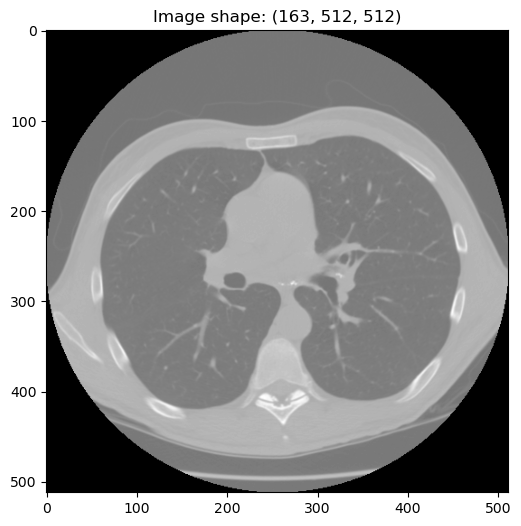

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/6644.nii.gz'

test_image_nib = nib.load(img_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig = plt.figure(figsize=(12, 6))
plt.imshow(test_image[82], cmap='gray')
plt.title(f'Image shape: {test_image.shape}')
plt.show()

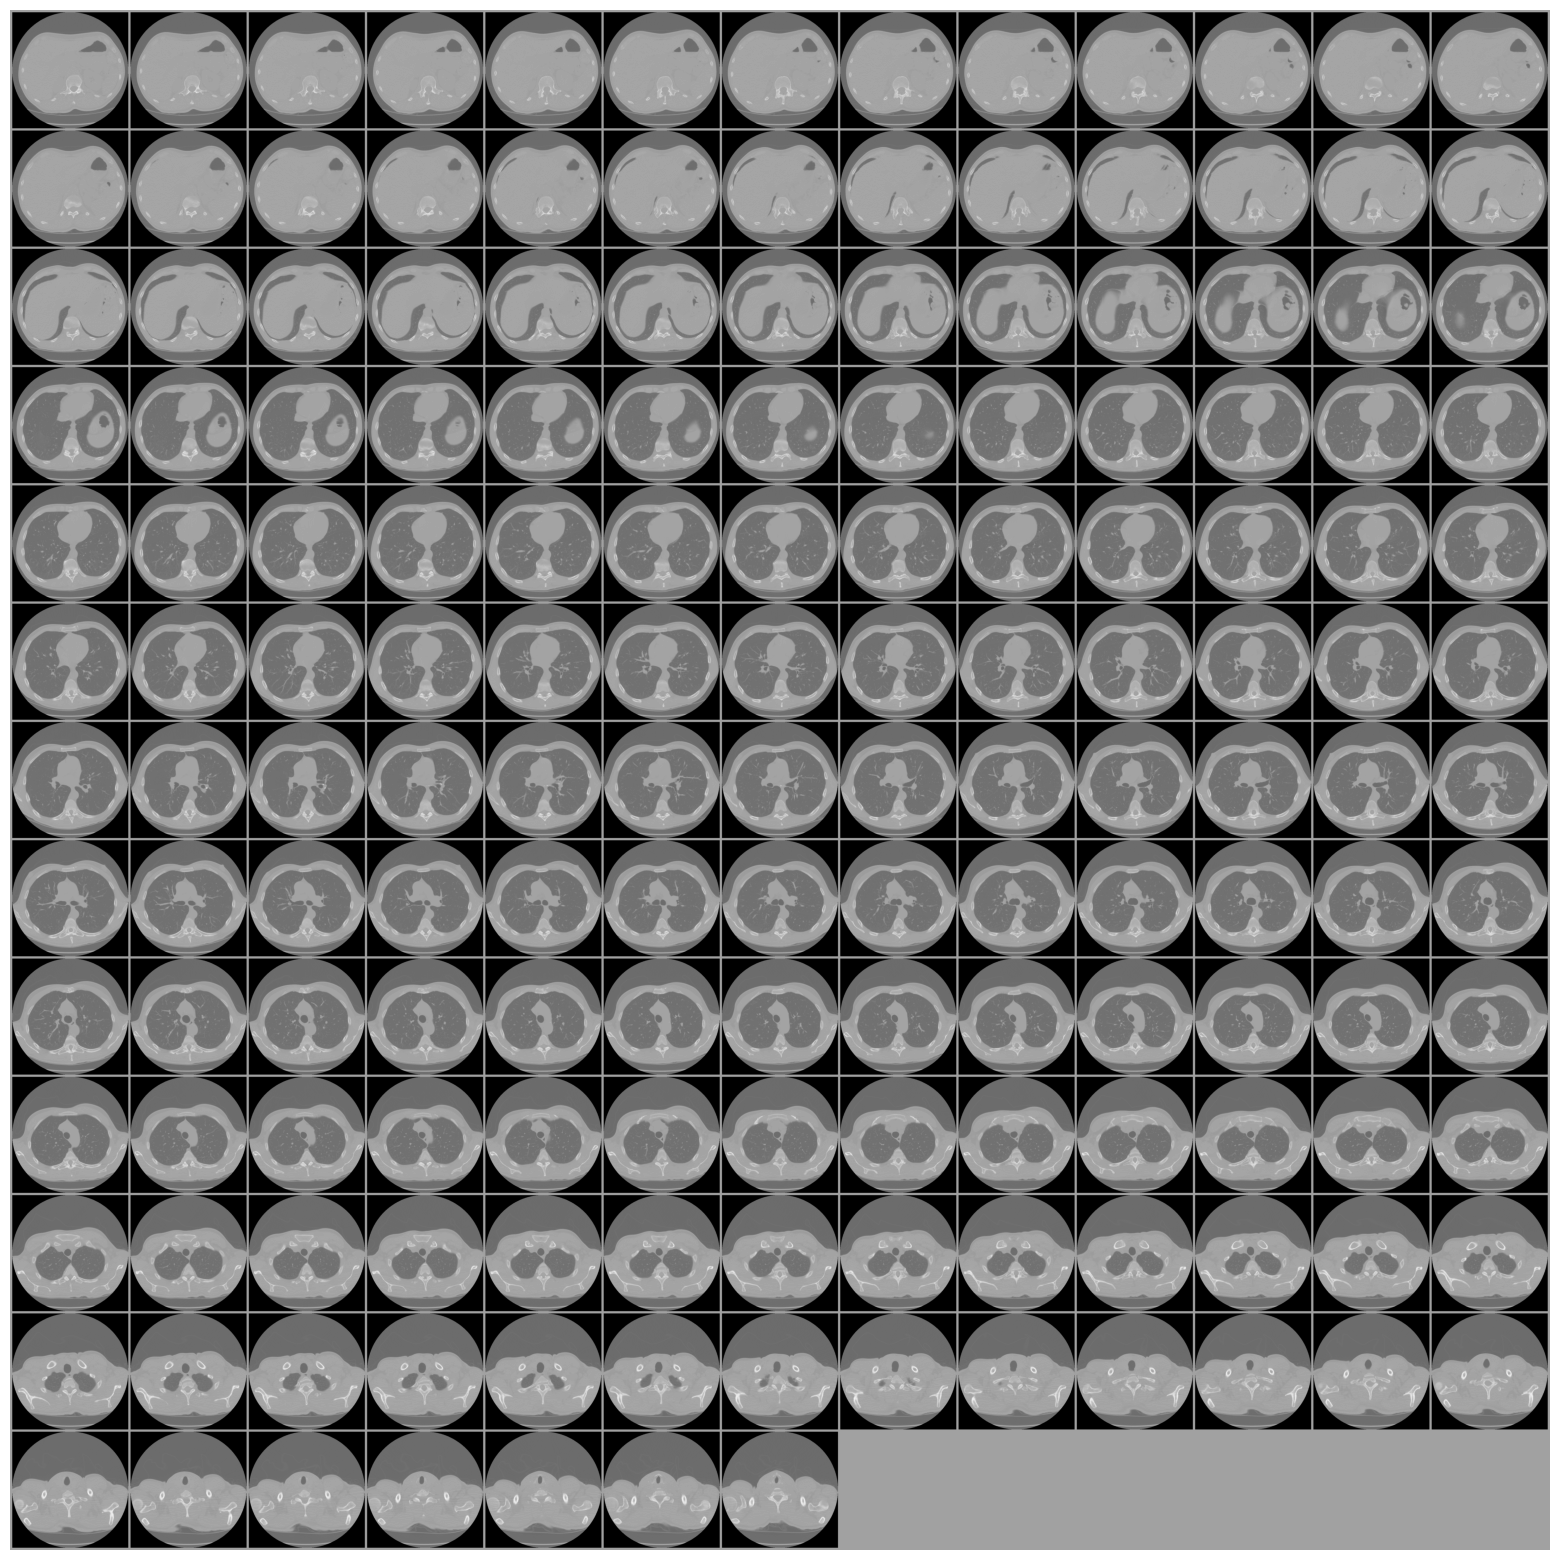

In [13]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

### Dataset

preparing jobs...
extracting and augmenting samples...
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1546   vox coord (zyx):  [159 243 183]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1045   vox coord (zyx):  [103 258 117]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 65 360 294]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 66 315  67]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 97 403 192]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [108 380 102]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 51 315 119]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 64 290 240]
Working on job: /home/natitov/hack_lct/le

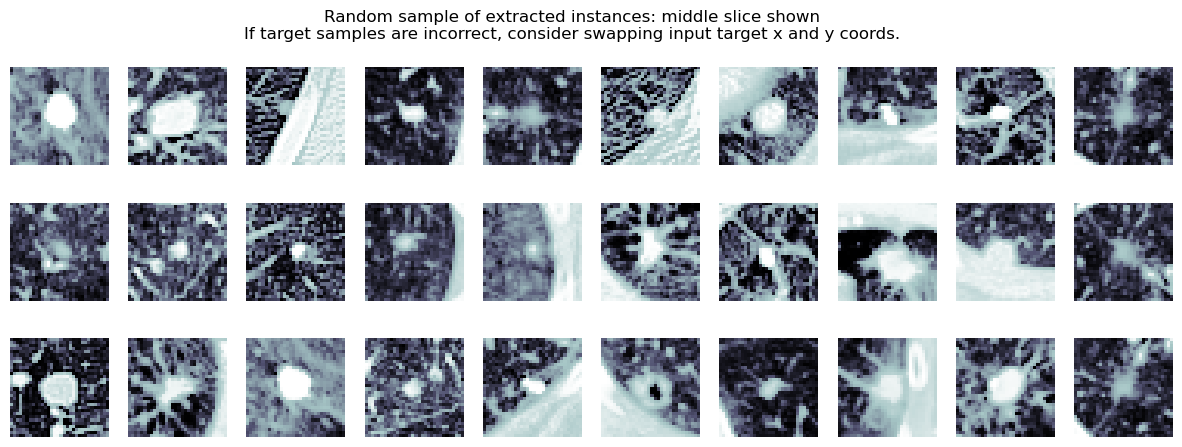

saving the dataset


In [21]:
from procedures.datasetBuilder import Extractor

builder = Extractor(is_healthy_dataset=False, parallelize=False)
builder.extract()

## Model

### Training

In [22]:
from procedures.trainer import Trainer

CTGAN_inj = Trainer(isInjector = False)
CTGAN_inj.train(epochs=200, batch_size=32, sample_interval=50)

2022-11-05 01:45:50.709693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2022-11-05 01:45:50.709752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-05 01:45:50.709761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2022-11-05 01:45:50.709767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2022-11-05 01:45:50.709899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30588 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)


loading preprocessed dataset...
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 32, 2 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
_______________________________________________________________________________________

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2022-11-05 01:46:00.787994: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.790598: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.820003: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-05 01:46:00.822286: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.


Instructions for updating:
Use tf.cast instead.
[Epoch 0/200] [Batch 0/43] [D loss: 0.743221, acc:  43%] [G loss: 53.773438] time: 0:00:35.569388
[Epoch 0/200] [Batch 1/43] [D loss: 0.624845, acc:  45%] [G loss: 62.148327] time: 0:00:37.404244
[Epoch 0/200] [Batch 2/43] [D loss: 0.598613, acc:  45%] [G loss: 46.176174] time: 0:00:38.457523
[Epoch 0/200] [Batch 3/43] [D loss: 0.495528, acc:  53%] [G loss: 40.326408] time: 0:00:39.518834
[Epoch 0/200] [Batch 4/43] [D loss: 0.472134, acc:  50%] [G loss: 31.060345] time: 0:00:40.565290
[Epoch 0/200] [Batch 5/43] [D loss: 0.397896, acc:  55%] [G loss: 28.894333] time: 0:00:41.632473
[Epoch 0/200] [Batch 6/43] [D loss: 0.364729, acc:  55%] [G loss: 22.316856] time: 0:00:42.685016
[Epoch 0/200] [Batch 7/43] [D loss: 0.313160, acc:  61%] [G loss: 19.345774] time: 0:00:43.753976
[Epoch 0/200] [Batch 8/43] [D loss: 0.341400, acc:  57%] [G loss: 25.545681] time: 0:00:44.799314
[Epoch 0/200] [Batch 9/43] [D loss: 0.286932, acc:  62%] [G loss: 21.7

0it [00:00, ?it/s]

[Epoch 1/200] [Batch 0/43] [D loss: 0.186334, acc:  72%] [G loss: 9.610813] time: 0:01:25.098934
[Epoch 1/200] [Batch 1/43] [D loss: 0.227336, acc:  65%] [G loss: 8.780621] time: 0:01:26.491947
[Epoch 1/200] [Batch 2/43] [D loss: 0.226754, acc:  65%] [G loss: 9.506457] time: 0:01:27.541686
[Epoch 1/200] [Batch 3/43] [D loss: 0.262185, acc:  59%] [G loss: 10.212909] time: 0:01:28.600320
[Epoch 1/200] [Batch 4/43] [D loss: 0.199536, acc:  73%] [G loss: 8.725226] time: 0:01:29.650939
[Epoch 1/200] [Batch 5/43] [D loss: 0.188100, acc:  72%] [G loss: 9.782982] time: 0:01:30.698849
[Epoch 1/200] [Batch 6/43] [D loss: 0.261076, acc:  58%] [G loss: 9.995776] time: 0:01:31.768094
[Epoch 1/200] [Batch 7/43] [D loss: 0.187874, acc:  73%] [G loss: 9.072487] time: 0:01:32.833269
[Epoch 1/200] [Batch 8/43] [D loss: 0.222177, acc:  65%] [G loss: 9.059361] time: 0:01:33.887537
[Epoch 1/200] [Batch 9/43] [D loss: 0.213441, acc:  70%] [G loss: 8.422582] time: 0:01:34.938442
[Epoch 1/200] [Batch 10/43] [

0it [00:00, ?it/s]

[Epoch 2/200] [Batch 0/43] [D loss: 0.154797, acc:  79%] [G loss: 8.307064] time: 0:02:12.864494
[Epoch 2/200] [Batch 1/43] [D loss: 0.147835, acc:  81%] [G loss: 8.579842] time: 0:02:14.237630
[Epoch 2/200] [Batch 2/43] [D loss: 0.182534, acc:  74%] [G loss: 8.492577] time: 0:02:15.288418
[Epoch 2/200] [Batch 3/43] [D loss: 0.169773, acc:  75%] [G loss: 8.695378] time: 0:02:16.338055
[Epoch 2/200] [Batch 4/43] [D loss: 0.141457, acc:  82%] [G loss: 8.082993] time: 0:02:17.384240
[Epoch 2/200] [Batch 5/43] [D loss: 0.138371, acc:  83%] [G loss: 8.973663] time: 0:02:18.430308
[Epoch 2/200] [Batch 6/43] [D loss: 0.173059, acc:  75%] [G loss: 8.157608] time: 0:02:19.483272
[Epoch 2/200] [Batch 7/43] [D loss: 0.138451, acc:  82%] [G loss: 7.984899] time: 0:02:20.543183
[Epoch 2/200] [Batch 8/43] [D loss: 0.145374, acc:  85%] [G loss: 8.740191] time: 0:02:21.587311
[Epoch 2/200] [Batch 9/43] [D loss: 0.173355, acc:  76%] [G loss: 8.605680] time: 0:02:22.636322
[Epoch 2/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 3/200] [Batch 0/43] [D loss: 0.155716, acc:  82%] [G loss: 7.749600] time: 0:03:00.509891
[Epoch 3/200] [Batch 1/43] [D loss: 0.148050, acc:  83%] [G loss: 7.768215] time: 0:03:01.890714
[Epoch 3/200] [Batch 2/43] [D loss: 0.170762, acc:  77%] [G loss: 7.736994] time: 0:03:02.935302
[Epoch 3/200] [Batch 3/43] [D loss: 0.127263, acc:  87%] [G loss: 7.776069] time: 0:03:03.986516
[Epoch 3/200] [Batch 4/43] [D loss: 0.148172, acc:  82%] [G loss: 7.754220] time: 0:03:05.037613
[Epoch 3/200] [Batch 5/43] [D loss: 0.113244, acc:  89%] [G loss: 8.188071] time: 0:03:06.083774
[Epoch 3/200] [Batch 6/43] [D loss: 0.148670, acc:  81%] [G loss: 7.535783] time: 0:03:07.141766
[Epoch 3/200] [Batch 7/43] [D loss: 0.128743, acc:  87%] [G loss: 7.592569] time: 0:03:08.194344
[Epoch 3/200] [Batch 8/43] [D loss: 0.113566, acc:  89%] [G loss: 8.417222] time: 0:03:09.240854
[Epoch 3/200] [Batch 9/43] [D loss: 0.137969, acc:  84%] [G loss: 7.721947] time: 0:03:10.295830
[Epoch 3/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 4/200] [Batch 0/43] [D loss: 0.122414, acc:  86%] [G loss: 7.183875] time: 0:03:48.249343
[Epoch 4/200] [Batch 1/43] [D loss: 0.145288, acc:  83%] [G loss: 7.183468] time: 0:03:49.643460
[Epoch 4/200] [Batch 2/43] [D loss: 0.151133, acc:  81%] [G loss: 7.819984] time: 0:03:50.690187
[Epoch 4/200] [Batch 3/43] [D loss: 0.087606, acc:  92%] [G loss: 8.211567] time: 0:03:51.740497
[Epoch 4/200] [Batch 4/43] [D loss: 0.134231, acc:  86%] [G loss: 7.550896] time: 0:03:52.799977
[Epoch 4/200] [Batch 5/43] [D loss: 0.132131, acc:  85%] [G loss: 7.632057] time: 0:03:53.842949
[Epoch 4/200] [Batch 6/43] [D loss: 0.136428, acc:  85%] [G loss: 7.129610] time: 0:03:54.891378
[Epoch 4/200] [Batch 7/43] [D loss: 0.129772, acc:  88%] [G loss: 7.235285] time: 0:03:55.942940
[Epoch 4/200] [Batch 8/43] [D loss: 0.123839, acc:  88%] [G loss: 7.456287] time: 0:03:57.007471
[Epoch 4/200] [Batch 9/43] [D loss: 0.109127, acc:  90%] [G loss: 7.033016] time: 0:03:58.052517
[Epoch 4/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 5/200] [Batch 0/43] [D loss: 0.157058, acc:  82%] [G loss: 7.836462] time: 0:04:35.921121
[Epoch 5/200] [Batch 1/43] [D loss: 0.130837, acc:  86%] [G loss: 7.543925] time: 0:04:37.324663
[Epoch 5/200] [Batch 2/43] [D loss: 0.164393, acc:  77%] [G loss: 7.174539] time: 0:04:38.369506
[Epoch 5/200] [Batch 3/43] [D loss: 0.132880, acc:  86%] [G loss: 8.012982] time: 0:04:39.430380
[Epoch 5/200] [Batch 4/43] [D loss: 0.126326, acc:  86%] [G loss: 6.973412] time: 0:04:40.508909
[Epoch 5/200] [Batch 5/43] [D loss: 0.140346, acc:  85%] [G loss: 7.563778] time: 0:04:41.552361
[Epoch 5/200] [Batch 6/43] [D loss: 0.113142, acc:  90%] [G loss: 7.155395] time: 0:04:42.600409
[Epoch 5/200] [Batch 7/43] [D loss: 0.145007, acc:  83%] [G loss: 6.956348] time: 0:04:43.655494
[Epoch 5/200] [Batch 8/43] [D loss: 0.161815, acc:  80%] [G loss: 7.783400] time: 0:04:44.702754
[Epoch 5/200] [Batch 9/43] [D loss: 0.133446, acc:  87%] [G loss: 7.610844] time: 0:04:45.756507
[Epoch 5/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 6/200] [Batch 0/43] [D loss: 0.109036, acc:  89%] [G loss: 11.358341] time: 0:05:23.661811
[Epoch 6/200] [Batch 1/43] [D loss: 0.101648, acc:  91%] [G loss: 10.737770] time: 0:05:25.318696
[Epoch 6/200] [Batch 2/43] [D loss: 0.075526, acc:  94%] [G loss: 10.040802] time: 0:05:26.365856
[Epoch 6/200] [Batch 3/43] [D loss: 0.055643, acc:  97%] [G loss: 9.726715] time: 0:05:27.414519
[Epoch 6/200] [Batch 4/43] [D loss: 0.051624, acc:  97%] [G loss: 8.798196] time: 0:05:28.461164
[Epoch 6/200] [Batch 5/43] [D loss: 0.037042, acc:  97%] [G loss: 9.193601] time: 0:05:29.523132
[Epoch 6/200] [Batch 6/43] [D loss: 0.036678, acc:  98%] [G loss: 8.178024] time: 0:05:30.583605
[Epoch 6/200] [Batch 7/43] [D loss: 0.031327, acc:  99%] [G loss: 7.856264] time: 0:05:31.639359
[Epoch 6/200] [Batch 8/43] [D loss: 0.038711, acc:  98%] [G loss: 8.257681] time: 0:05:32.713346
[Epoch 6/200] [Batch 9/43] [D loss: 0.035626, acc:  98%] [G loss: 8.243845] time: 0:05:33.757149
[Epoch 6/200] [Batch 10/43]

0it [00:00, ?it/s]

[Epoch 7/200] [Batch 0/43] [D loss: 0.081695, acc:  94%] [G loss: 6.600644] time: 0:06:11.801408
[Epoch 7/200] [Batch 1/43] [D loss: 0.102389, acc:  94%] [G loss: 6.638566] time: 0:06:13.200291
[Epoch 7/200] [Batch 2/43] [D loss: 0.128310, acc:  87%] [G loss: 7.257617] time: 0:06:14.252010
[Epoch 7/200] [Batch 3/43] [D loss: 0.061429, acc:  97%] [G loss: 7.492013] time: 0:06:15.313093
[Epoch 7/200] [Batch 4/43] [D loss: 0.115560, acc:  90%] [G loss: 6.415052] time: 0:06:16.370586
[Epoch 7/200] [Batch 5/43] [D loss: 0.083500, acc:  94%] [G loss: 7.044979] time: 0:06:17.421297
[Epoch 7/200] [Batch 6/43] [D loss: 0.091189, acc:  95%] [G loss: 6.904586] time: 0:06:18.470251
[Epoch 7/200] [Batch 7/43] [D loss: 0.069650, acc:  97%] [G loss: 7.650050] time: 0:06:19.528879
[Epoch 7/200] [Batch 8/43] [D loss: 0.126158, acc:  85%] [G loss: 7.050667] time: 0:06:20.575385
[Epoch 7/200] [Batch 9/43] [D loss: 0.152303, acc:  81%] [G loss: 7.773936] time: 0:06:21.625731
[Epoch 7/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 8/200] [Batch 0/43] [D loss: 0.117194, acc:  90%] [G loss: 6.570231] time: 0:06:59.572061
[Epoch 8/200] [Batch 1/43] [D loss: 0.097846, acc:  93%] [G loss: 7.509249] time: 0:07:00.949606
[Epoch 8/200] [Batch 2/43] [D loss: 0.102501, acc:  91%] [G loss: 7.170396] time: 0:07:02.005256
[Epoch 8/200] [Batch 3/43] [D loss: 0.110895, acc:  92%] [G loss: 7.243416] time: 0:07:03.057817
[Epoch 8/200] [Batch 4/43] [D loss: 0.149214, acc:  85%] [G loss: 6.220415] time: 0:07:04.110797
[Epoch 8/200] [Batch 5/43] [D loss: 0.101772, acc:  92%] [G loss: 6.652101] time: 0:07:05.156816
[Epoch 8/200] [Batch 6/43] [D loss: 0.102676, acc:  92%] [G loss: 6.491084] time: 0:07:06.215734
[Epoch 8/200] [Batch 7/43] [D loss: 0.100377, acc:  94%] [G loss: 7.174103] time: 0:07:07.271229
[Epoch 8/200] [Batch 8/43] [D loss: 0.061420, acc:  96%] [G loss: 7.443416] time: 0:07:08.324586
[Epoch 8/200] [Batch 9/43] [D loss: 0.105320, acc:  91%] [G loss: 6.398329] time: 0:07:09.372244
[Epoch 8/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 9/200] [Batch 0/43] [D loss: 0.112379, acc:  90%] [G loss: 6.303183] time: 0:07:47.329212
[Epoch 9/200] [Batch 1/43] [D loss: 0.091149, acc:  94%] [G loss: 6.105872] time: 0:07:48.711814
[Epoch 9/200] [Batch 2/43] [D loss: 0.099464, acc:  94%] [G loss: 7.164704] time: 0:07:49.771792
[Epoch 9/200] [Batch 3/43] [D loss: 0.071138, acc:  97%] [G loss: 6.826684] time: 0:07:50.823536
[Epoch 9/200] [Batch 4/43] [D loss: 0.149030, acc:  86%] [G loss: 6.363828] time: 0:07:51.879401
[Epoch 9/200] [Batch 5/43] [D loss: 0.056689, acc:  97%] [G loss: 7.244742] time: 0:07:52.925889
[Epoch 9/200] [Batch 6/43] [D loss: 0.112311, acc:  89%] [G loss: 6.404195] time: 0:07:53.982513
[Epoch 9/200] [Batch 7/43] [D loss: 0.093475, acc:  95%] [G loss: 6.780133] time: 0:07:55.029168
[Epoch 9/200] [Batch 8/43] [D loss: 0.104755, acc:  93%] [G loss: 6.699471] time: 0:07:56.103183
[Epoch 9/200] [Batch 9/43] [D loss: 0.101840, acc:  93%] [G loss: 6.133845] time: 0:07:57.164745
[Epoch 9/200] [Batch 10/43] [D

0it [00:00, ?it/s]

[Epoch 10/200] [Batch 0/43] [D loss: 0.080322, acc:  97%] [G loss: 6.183451] time: 0:08:35.143475
[Epoch 10/200] [Batch 1/43] [D loss: 0.086620, acc:  97%] [G loss: 6.210276] time: 0:08:36.543503
[Epoch 10/200] [Batch 2/43] [D loss: 0.083646, acc:  95%] [G loss: 6.187283] time: 0:08:37.589412
[Epoch 10/200] [Batch 3/43] [D loss: 0.119154, acc:  90%] [G loss: 7.392509] time: 0:08:38.645259
[Epoch 10/200] [Batch 4/43] [D loss: 0.075699, acc:  95%] [G loss: 6.341710] time: 0:08:39.700009
[Epoch 10/200] [Batch 5/43] [D loss: 0.111377, acc:  89%] [G loss: 10.437460] time: 0:08:40.747370
[Epoch 10/200] [Batch 6/43] [D loss: 0.588955, acc:  56%] [G loss: 9.873007] time: 0:08:41.805070
[Epoch 10/200] [Batch 7/43] [D loss: 0.294867, acc:  68%] [G loss: 14.417603] time: 0:08:42.853134
[Epoch 10/200] [Batch 8/43] [D loss: 0.182853, acc:  78%] [G loss: 12.515039] time: 0:08:43.898023
[Epoch 10/200] [Batch 9/43] [D loss: 0.145907, acc:  81%] [G loss: 9.342863] time: 0:08:44.957664
[Epoch 10/200] [B

0it [00:00, ?it/s]

[Epoch 11/200] [Batch 0/43] [D loss: 0.044965, acc:  98%] [G loss: 6.280687] time: 0:09:22.910291
[Epoch 11/200] [Batch 1/43] [D loss: 0.056775, acc:  98%] [G loss: 6.690747] time: 0:09:24.317076
[Epoch 11/200] [Batch 2/43] [D loss: 0.075914, acc:  93%] [G loss: 6.333121] time: 0:09:25.373073
[Epoch 11/200] [Batch 3/43] [D loss: 0.037800, acc:  99%] [G loss: 7.200413] time: 0:09:26.423134
[Epoch 11/200] [Batch 4/43] [D loss: 0.045769, acc:  99%] [G loss: 6.454013] time: 0:09:27.478197
[Epoch 11/200] [Batch 5/43] [D loss: 0.051416, acc:  97%] [G loss: 6.319767] time: 0:09:28.526184
[Epoch 11/200] [Batch 6/43] [D loss: 0.054092, acc:  97%] [G loss: 6.346334] time: 0:09:29.577867
[Epoch 11/200] [Batch 7/43] [D loss: 0.038578, acc:  99%] [G loss: 6.880926] time: 0:09:30.638698
[Epoch 11/200] [Batch 8/43] [D loss: 0.045276, acc:  98%] [G loss: 6.427275] time: 0:09:31.704593
[Epoch 11/200] [Batch 9/43] [D loss: 0.083877, acc:  94%] [G loss: 6.161899] time: 0:09:32.751890
[Epoch 11/200] [Batc

0it [00:00, ?it/s]

[Epoch 12/200] [Batch 0/43] [D loss: 0.072474, acc:  97%] [G loss: 5.972169] time: 0:10:10.699356
[Epoch 12/200] [Batch 1/43] [D loss: 0.087131, acc:  96%] [G loss: 6.359953] time: 0:10:12.078951
[Epoch 12/200] [Batch 2/43] [D loss: 0.090657, acc:  94%] [G loss: 6.111975] time: 0:10:13.125420
[Epoch 12/200] [Batch 3/43] [D loss: 0.056793, acc:  97%] [G loss: 7.089989] time: 0:10:14.186361
[Epoch 12/200] [Batch 4/43] [D loss: 0.063860, acc:  98%] [G loss: 6.134470] time: 0:10:15.239407
[Epoch 12/200] [Batch 5/43] [D loss: 0.051133, acc:  98%] [G loss: 6.155272] time: 0:10:16.287976
[Epoch 12/200] [Batch 6/43] [D loss: 0.057195, acc:  98%] [G loss: 5.938193] time: 0:10:17.362876
[Epoch 12/200] [Batch 7/43] [D loss: 0.055154, acc:  99%] [G loss: 6.451108] time: 0:10:18.414454


### Inference

In [ ]:
from procedures.attack_pipeline import scan_manipulator
import numpy as np

injector = scan_manipulator()
injector.load_target_scan('../data/healthy_scans/1546')

# Inject at two locations
locations = [ # z,y,x (x-y should be flipped if the coordinates were obtained from an image viewer)
    [159,300,330],
    [159,350,350],
]
for loc in locations:
    vox_coord = np.array(loc)
    injector.tamper(vox_coord, action='inject', isVox=True) # can supply world coord too

injector.save_tampered_scan('../data/inference/0', output_type='dicom') # output can be dicom or numpy

In [7]:
!python ../utils/dicom_to_nifti.py -i ../data/inference/0 -o ../data/inference/0.nii.gz

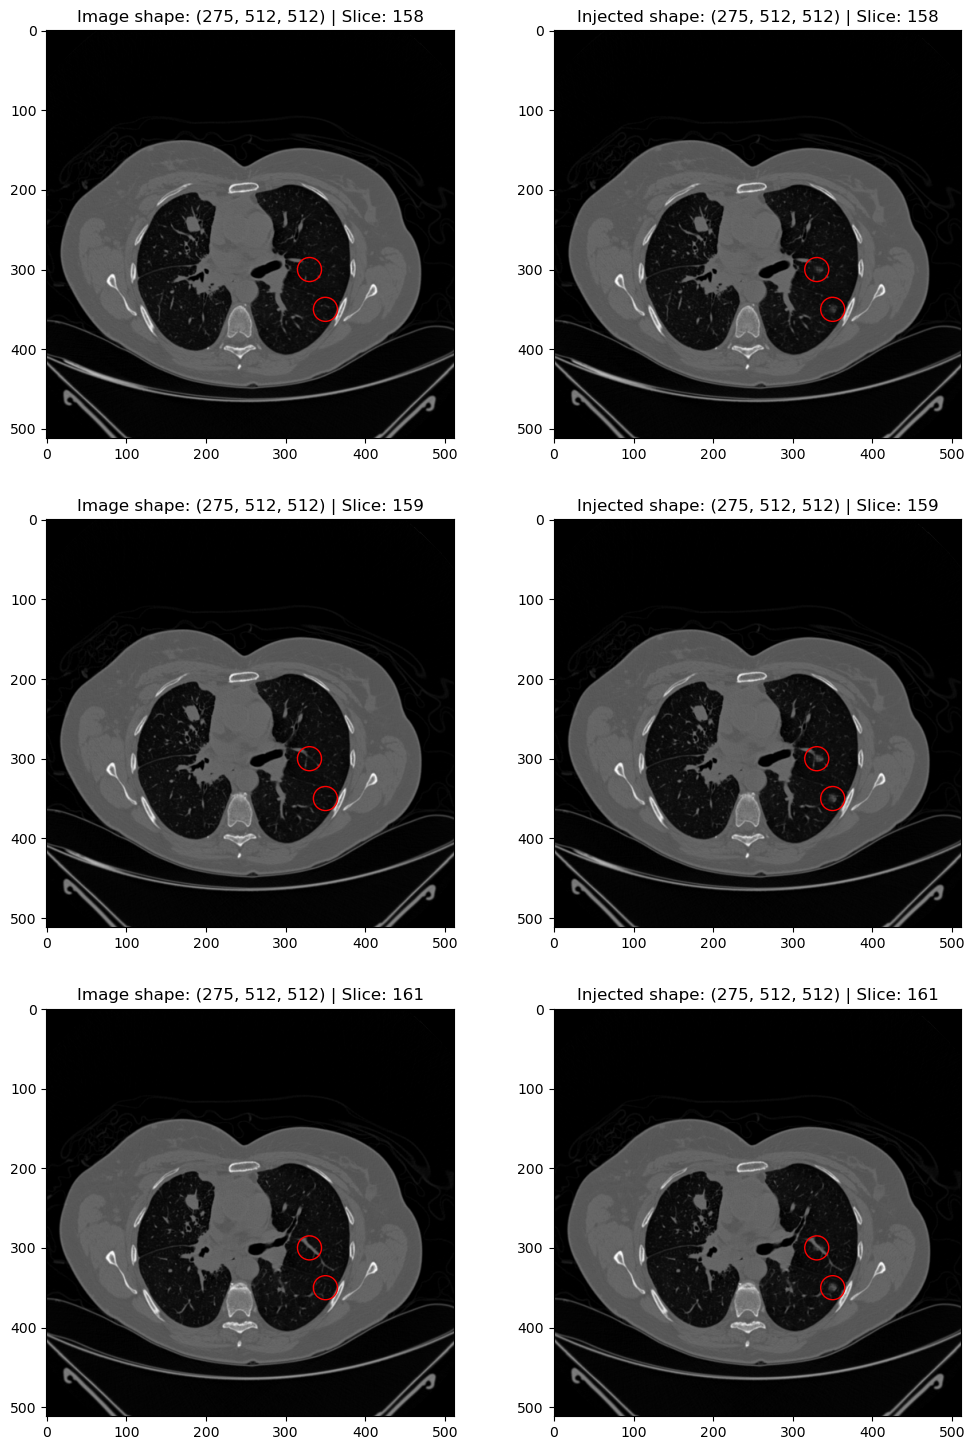

In [8]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'
injected_path = '../data/inference/0.nii.gz'

test_image_nib = nib.load(img_path)
test_injected_nib = nib.load(injected_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_injected = np.transpose(test_injected_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

locations = [
    [158, 159, 161],
    [330,350],
    [300,350],
]
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, z in enumerate(locations[0]):
    axs[i, 0].imshow(test_image[z], cmap='gray')
    axs[i, 0].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 0].set_title(f'Image shape: {test_image.shape} | Slice: {z}')
    axs[i, 1].imshow(test_injected[z], cmap='gray')
    axs[i, 1].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 1].set_title(f'Injected shape: {test_injected.shape} | Slice: {z}')
plt.show()